# Detecting Osteoarthritis with Deep Learning

#### DTSA 5511: Introduction to Deep Learning

In this notebook, I'll import, explore, and clean a set of knee x-ray images, use it to predict the presence and severity of osteoarthritis, and reflect on key findings.

The full GitHub repo for this project can be found at https://github.com/23ccozad/osteoarthritis-x-ray-classification.

First, I'll begin by importing the libraries needed to run this notebook.

In [51]:
from collections import defaultdict, Counter
import hashlib
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical

### Gather data, determine the method of data collection and provenance of the data (1 point)

*Instructions: In the earliest phase, select a data source and problem.*


I retrieved this [Digital Knee X-ray](https://www.kaggle.com/datasets/orvile/digital-knee-x-ray-images) dataset from Kaggle. It contains thousands of x-ray images of knees, along with a Kellgren-Lawrence grade for each, which indicates the severity of osteoarthritis present in the image.

In [2]:
image_dir = '/content/drive/MyDrive/CU Boulder Data Science/DTSA 5511 - Introduction to Deep Learning/Final Project/images/MedicalExpert-I/MedicalExpert-I'
class_names = os.listdir(image_dir)

Let's import the image pixel data and the associated labels.

In [3]:
data = []
for label in class_names:
    folder_path = os.path.join(image_dir, label)
    if not os.path.isdir(folder_path):
        continue
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            fpath = os.path.join(folder_path, fname)
            img = Image.open(fpath).convert('RGB')
            data.append((np.array(img), label))
            img.close()
    print(f"Loaded {len(os.listdir(folder_path))} images from {label} class")

Loaded 514 images from 0Normal class
Loaded 477 images from 1Doubtful class
Loaded 232 images from 2Mild class
Loaded 221 images from 3Moderate class
Loaded 206 images from 4Severe class


Here's a random image from the dataset alongside its label.

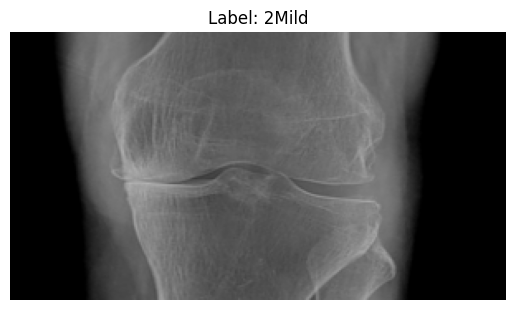

In [4]:
random.seed(30)
img, label = random.choice(data)
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

The **source and provenance** are made clear on the Kaggle dataset page. The reccomended citation is:

> Gornale, Prof. Shivanand; Patravali, Pooja (2020), “Digital Knee X-ray Images”, Mendeley Data, V1, doi: 10.17632/t9ndx37v5h.1

The data came from Rani Channamma University and was published in 2020. DOI: 10.17632/t9ndx37v5h.1

The **problem** I'll attempt to solve is determining the Kellgren-Lawrence grade for osteoarthritis severity  from x-ray images of knee joints. This would be a valuable tool for doctors to corroborate there x-ray based diagnoses for this condition.

### Identify a Deep Learning Problem (5 points)

*Instructions: If you're going to use a Kaggle competition or similar, you must focus more on model building and/or analysis to be a valid project.*

**Problem**: Determine the Kellgren-Lawrence grade for osteoarthritis severity from x-ray images of knee joints.

Osteoarthritis is a condition more commonly found in older people that occurs when the cartilage and bone around joints break down. This condition causes pain, stiffness, and restricts movement. Detecting this early can help doctors and patients manage symptoms. Therefore, correctly assessing the severity of the conidition is important. This deep learning model will be able to help address this issue.

**Proposed solution**: With a dataset of thousands of knee x-rays, along with labels of the Kellgren-Lawrence grade performed by doctors for each image, I'll train a deep learning model to predict the grade for unseen images. Doctors can use this tool to compare with their own assessment of the x-ray and hopefully improve patient outcomes.

**Model building and training** will be a key part of this project. I will explore different deep learning models and architectures, and then compare their performance to find the best solution.

### Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)

*Instructions:*

* *Go through the initial data cleaning and EDA and judge whether you need to collect more or different data.*

* *Describe the factors or components that make up the dataset. For each factor, use a box-plot, scatter plot, histogram, etc., to describe the data distribution as appropriate.*

* *Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.*

* *Determine if any data needs to be transformed. For example, if you're planning on using an SVM method for prediction, you may need to normalize or scale the data if there is a considerable difference in the range of the data.*

* *Using your hypothesis, indicate if it's likely that you should transform data, such as using a log transform or other transformation of the dataset.*

* *You should determine if your data has outliers or needs to be cleaned in any way. Are there missing data values for specific factors? How will you handle the data cleaning? Will you discard, interpolate or otherwise substitute data values?*

* *If you believe that specific factors will be more important than others in your analysis, you should mention which and why. You will use this to confirm your intuitions in your final write-up.*

#### Dataset size

The dataset has 1,650 images.

In [5]:
len(data)

1650

Each item in the list is a tuple, where the first element is the image stored as a numpy array, and the second element is the label for the image.

Let's take a look at the shape of the image data:

array([[[ 74,  74,  74],
        [ 77,  77,  77],
        [ 79,  79,  79],
        ...,
        [141, 141, 141],
        [142, 142, 142],
        [143, 143, 143]],

       [[ 70,  70,  70],
        [ 74,  74,  74],
        [ 81,  81,  81],
        ...,
        [139, 139, 139],
        [141, 141, 141],
        [141, 141, 141]],

       [[ 70,  70,  70],
        [ 73,  73,  73],
        [ 79,  79,  79],
        ...,
        [141, 141, 141],
        [142, 142, 142],
        [141, 141, 141]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [104, 104, 104],
        [103, 103, 103],
        [101, 101, 101]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [103, 103, 103],
        [103, 103, 103],
        [100, 100, 100]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [103, 103, 103],
        [101, 101, 101],
        [ 99,  99,  99]]], dtype=uint8)
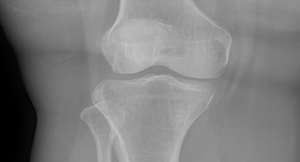

In [6]:
data[0][0]

It appears the images are 162x300 pixels, with three channels. However, these are **grayscale images**, so we only need one channel. Let's see if we can **reduce the three channels to one channel**. Here's a preview of the 3 channels for the first five pixels in the first image in the dataset:

In [7]:
data[0][0][0][0:5]

array([[74, 74, 74],
       [77, 77, 77],
       [79, 79, 79],
       [83, 83, 83],
       [85, 85, 85]], dtype=uint8)

#### Reduce three image channels to one

A preview of the first 5 pixels in the array printed out above shows that, since the image is grayscale, the pixel value in each channel is identical. Therefore, we can get rid of the other two channels.

In [8]:
grayscale_data = []

for img, label in data:
    gray_img = np.mean(img, axis=2).astype(np.uint8)
    grayscale_data.append((gray_img, label))

Here's a preview of the first image again, still looks the same (that's good!), except only one color channel now.

array([[ 74,  77,  79, ..., 141, 142, 143],
       [ 70,  74,  81, ..., 139, 141, 141],
       [ 70,  73,  79, ..., 141, 142, 141],
       ...,
       [  0,   0,   0, ..., 104, 103, 101],
       [  0,   0,   0, ..., 103, 103, 100],
       [  0,   0,   0, ..., 103, 101,  99]], dtype=uint8)
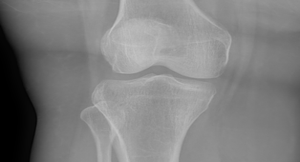

In [9]:
grayscale_data[0][0]

Since this looks good, we can move forward cleaning and exploring the data.

In [10]:
data = grayscale_data

#### Make sure all images are same size

I saw some of the images in the dataset are not the right size. Let's see how many images have different dimensions:

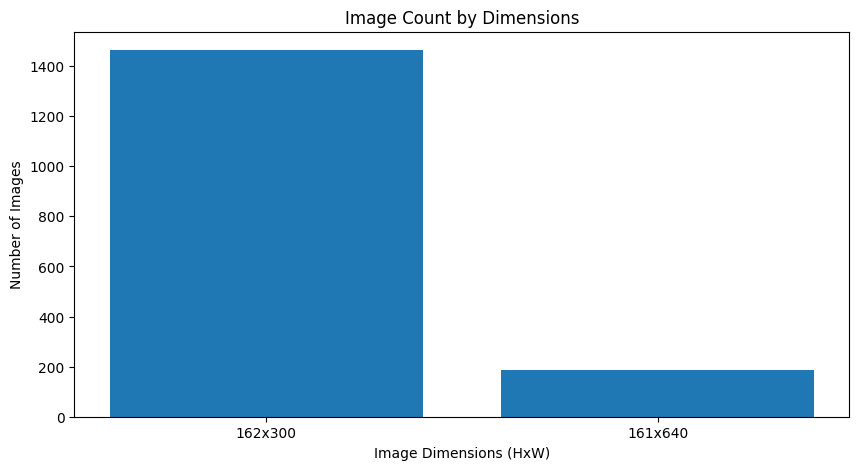

In [11]:
size_counts = {}

for img, _ in data:
    size_counts[img.shape] = size_counts.get(img.shape, 0) + 1

sizes = list(size_counts.keys())
counts = list(size_counts.values())

size_labels = [f"{h}x{w}" for h, w in sizes]

plt.figure(figsize=(10, 5))
plt.bar(size_labels, counts)
plt.xlabel("Image Dimensions (HxW)")
plt.ylabel("Number of Images")
plt.title("Image Count by Dimensions")
plt.show()

Ok, so we have a few hundred images here that are 161x640 pixels. They look like this, where the x-ray includes both knees. Most of the x-ray images only include one knee.

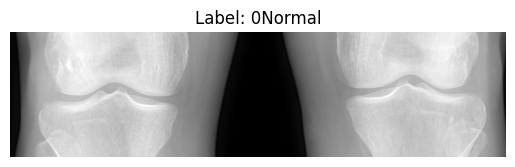

In [12]:
for img, label in data:
    if img.shape ==  (161, 640):
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()
        break

I will need to **crop these wide images down to 161x300** so they just include one knee only, matching the rest of the dataset.

In [13]:
cropped_data = []

for img, label in data:
    if img.shape[:2] == (161, 640):
        cropped_img = img[:, :300]  # Crop the image
        cropped_data.append((cropped_img, label))
    else:
        cropped_data.append((img, label))  # Don't crop, keep as is

Here's what the wide image above now looks like cropped.

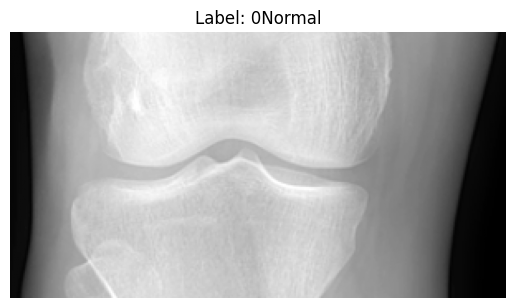

In [14]:
for img, label in cropped_data:
    if img.shape ==  (161, 300):
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()
        break

So now we are left with some images that are 162x300 and 161x300. Let's crop one pixel off the bottom of the 162x300 images so that we're consistent across all images.

In [15]:
cropped_data2 = []

for img, label in cropped_data:
    if img.shape[:2] == (162, 300):
        cropped_img = img[:-1, :]  # Crop the image
        cropped_data2.append((cropped_img, label))
    else:
        cropped_data2.append((img, label))  # Don't crop, keep as is

Let's check and make sure all images are the same size now.

In [16]:
data = cropped_data2

In [17]:
unique_shapes = set(img.shape[:2] for img, _ in data)
print("Unique image shapes after cropping:", unique_shapes)

Unique image shapes after cropping: {(161, 300)}


Great, all images are 161x300. Ready to move on!

#### View random image from each class

Let's see if there's any issues that appear with the images between the 5 classes. I'll check this by plotting a random image from each class and visually inspecting them, not just for errors, but to get an understanding of the differences in the images between classes as well.

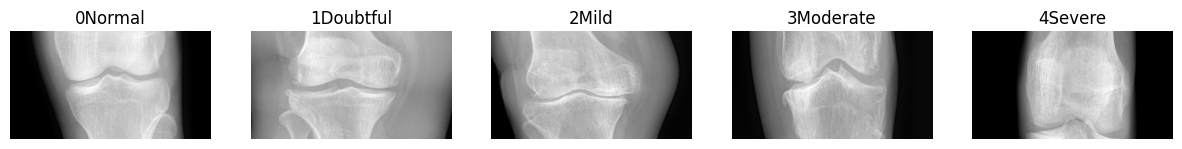

In [18]:
class_to_images = defaultdict(list)
for img, label in data:
    class_to_images[label].append(img)

# Plot one random image from each class
plt.figure(figsize=(15, 3))
for i, (label, images) in enumerate(class_to_images.items()):
    random.seed(30)
    img = random.choice(images)
    plt.subplot(1, len(class_to_images), i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()

The x-ray images for "0Normal" look pretty healthy, with good spacing between the two bones at the join. When we go further to the right, especially in "3Moderate" and "4Severe", there seems to be more signs of breakdown around the joint, and less spacing between the bones. I'm not in the medical field, but I'm sure this is something the model will pick up on.

#### Check for duplicate images

When we train the model, it's ideal to not have any duplicate images. We can check quickly by **hashing each image and comparing hashes** to determine whether two separate images have the exact same content:

In [19]:
def hash_image(img):
    return hashlib.md5(img.tobytes()).hexdigest()

In [20]:
hashes = {}
duplicates = []

for idx, (img, label) in enumerate(data):
    h = hash_image(img)
    if h in hashes:
        duplicates.append((idx, hashes[h]))
    else:
        hashes[h] = idx

print(f"Found {len(duplicates)} duplicate images.")

Found 76 duplicate images.


There are 76 duplicate images in the dataset. I'll go ahead and **remove the duplicates**.

In [21]:
duplicate_indices = set(dup_idx for dup_idx, _ in duplicates)
data = [item for idx, item in enumerate(data) if idx not in duplicate_indices]

Since there were 76 duplicates found, we should be left with 1,574 images:

In [22]:
len(data)

1574

Great, we're ready to move on!

#### Examine label distribution

It's also important to be aware of the distribution of labels in the dataset. Here's a plot of how many images we have in each group:

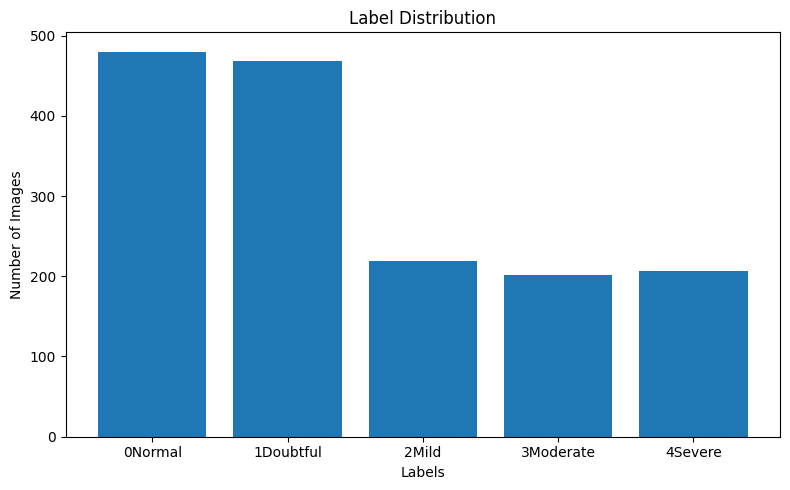

In [23]:
labels = [label for _, label in data]
label_counts = Counter(labels)

plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Label Distribution')
plt.tight_layout()
plt.show()

As is often the case, the more extreme the condition, the fewer images there are. This is seen often in machine learning. One way to solve the imbalance is to drop images from the "0Normal" and "1Doubtful" classes to even them out. However, That would be dropping a large chunk of images from a dataset that already isn't very big. So, for now, I'll elect to keep all the images. But certainly want to keep this in mind.

#### Plot distribution of pixel values

Let's also explore the different pixel values in some images. Here's the distribution of pixel values from a random image:

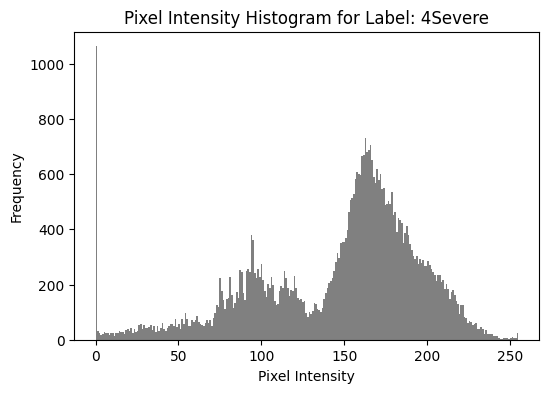

In [24]:
random.seed(10)
pixels = random.choice(images).flatten()

plt.figure(figsize=(6,4))
plt.hist(pixels, bins=256, range=(0,255), color='gray')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title(f'Pixel Intensity Histogram for Label: {label}')
plt.show()

I notice a lot of zeros in this dataset, which signify pixels colored black. That bar on the histogram is so high because the background of the x-ray is black, as expected. The bone is then visible in various gray colors, signified by the rest of the histogram.

#### Normalize pixel values

We see in the histogram above that the pixels are within the range [0, 255]. Deep learning algorithms tend to perform best when data is in the range [0, 1], so I'll use **normalize the pixel values to [0, 1]**.

In [25]:
for i in range(len(data)):
    img, label = data[i]
    data[i] = (img.astype('float32') / 255.0, label)

Let's verify that all pixel values are between 0 and 1 now.

In [26]:
all_within_range = True

for img, label in data:
    if img.min() < 0 or img.max() > 1:
        print(f"Image with label '{label}' has pixels outside [0, 1]: min={img.min()}, max={img.max()}")
        all_within_range = False

if all_within_range:
    print("All images have pixel values between 0 and 1.")

All images have pixel values between 0 and 1.


Looking good! All pixel values are between 0 and 1.

#### Shuffle dataset

Now, I want to make sure the data is shuffled, so that the **images should be presented to the models in no particular order**. Some of the images may have been shuffled in some way during the data cleaning process, but this guarentees that there is no order to them.

In [27]:
random.shuffle(data)

### Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)

*Instructions: Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression). Depending on your project, you may have one model or more. Generally, it is deemed a higher quality project if you compare multiple models and show your understanding of why specific models work better than the other or what limitations or cautions specific models may have. For machine learning models, another recommendation is to show enough effort on the hyperparameter optimization.*

#### Train/test split

The neural network will require the image and label data in a specific, multidimensional array format. Here, I split the images and labels into `X` and `y`, and add an additional axis to `X`. I also downsampled the images down to 80 x 149, since the models were taking too long to train at the full resolution.

In [28]:
images, labels = zip(*data)
X = np.array([cv2.resize(img.squeeze(), (80, 149)) for img in images], dtype=np.float32)
y = np.array([int(label[0]) for label in labels], dtype=np.int64)
X = X[..., np.newaxis]

Then, split the data into training (80%) and testing (20%) datasets.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10,
)

#### Fit an artificial neural network

As a baseline, I'll fit a simple artificial neural network. We can compare more complex models fitted later on with this simpler one and see how performance improves.

In [30]:
X.shape

(1574, 149, 80, 1)

In [31]:
simple_ann = Sequential([
    Flatten(input_shape=(80, 149, 1)),
    Dense(128, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

optimizer = Adam(learning_rate=0.000001)
simple_ann.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

simple_ann_history = simple_ann.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

loss, accuracy = simple_ann.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.1649 - loss: 1.7614 - val_accuracy: 0.3175 - val_loss: 1.6303
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3123 - loss: 1.5684 - val_accuracy: 0.3651 - val_loss: 1.5960
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3504 - loss: 1.5252 - val_accuracy: 0.3333 - val_loss: 1.5846
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3323 - loss: 1.5350 - val_accuracy: 0.3175 - val_loss: 1.5768
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3237 - loss: 1.5307 - val_accuracy: 0.3175 - val_loss: 1.5704
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3501 - loss: 1.5040 - val_accuracy: 0.3175 - val_loss: 1.5655
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3725 - loss: 1.4835 - val_accuracy: 0.3175 - val_loss: 1.5600
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3742 - loss: 1.4980 - val_accuracy: 0.3175 - v

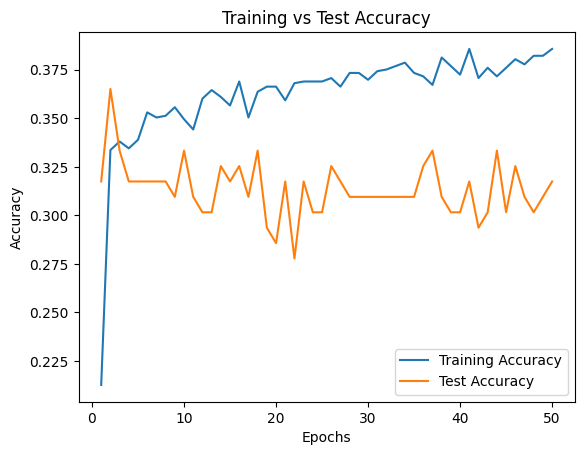

In [32]:
train_acc = simple_ann_history.history['accuracy']
val_acc = simple_ann_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.show()

I tried **adjusting the learning rate and number of epochs** and was able to improve the smoothness of the accuracy curves in the plot above. However, the curves above are still very noisy nonetheless. Additionally, the accuracy on unseen data is not great and could likely be improved by using a model that is better equipped to classify image data.

#### Fit a simple convolutional neural network

Convolutional neural networks (CNNs) are known to have **better performance** than regular neural networks **on image data**.

In [33]:
simple_cnn = Sequential([
    Input(shape=(80, 149, 1)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
simple_cnn.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

simple_cnn_history = simple_cnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

loss, acc = simple_cnn.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 548ms/step - accuracy: 0.3171 - loss: 1.5310 - val_accuracy: 0.2778 - val_loss: 1.5496
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 551ms/step - accuracy: 0.3250 - loss: 1.5008 - val_accuracy: 0.2778 - val_loss: 1.5542
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 586ms/step - accuracy: 0.2905 - loss: 1.5115 - val_accuracy: 0.3254 - val_loss: 1.5193
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 614ms/step - accuracy: 0.3471 - loss: 1.4617 - val_accuracy: 0.2857 - val_loss: 1.4956
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 575ms/step - accuracy: 0.3991 - loss: 1.4254 - val_accuracy: 0.3413 - val_loss: 1.4830
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 578ms/step - accuracy: 0.4087 - loss: 1.4019 - val_accuracy: 0.3333 - val_loss: 1.4911
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 608ms/step - accuracy: 0.4135 - loss: 1.3732 - val_accuracy: 0.3571 - val_loss: 1.4209
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 588ms/step - accuracy: 0.4360 - loss: 1.3621 - val_accu

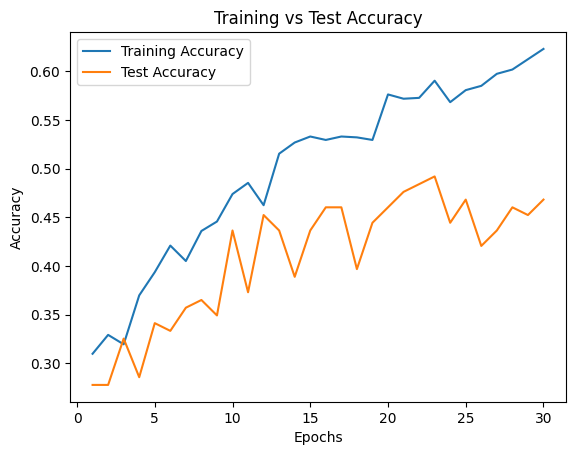

In [34]:
train_acc = simple_cnn_history.history['accuracy']
val_acc = simple_cnn_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.show()

The CNN certainly takes longer to train than a regular neural network. However, it does show better accuracy on the image classification task. I adjusted the learning rate and number of epochs to try to get a smoother learning curve, but there is certainly still some noise. I notice that the increase in accuracy on the validation dataset plateaus after about 15 to 20 epochs, indicating the model may have converged by that point.

#### Fit a convolutional neural network with batch normalization

Batch normalization is a technique that **normalizes the data in each training batch**, which has an effect **similar to regularization** on the model. It can make training more stable and lead to faster model convergence. I implemented it here after each convolutional layer:

In [35]:
batch_norm_cnn = Sequential([
    Input(shape=(80, 149, 1)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(len(set(y)), activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
batch_norm_cnn.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

batch_norm_cnn_history = batch_norm_cnn.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

loss, acc = batch_norm_cnn.evaluate(X_test, y_test)
print(f"Test accuracy: {acc:.4f}")

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 993ms/step - accuracy: 0.3403 - loss: 1.8786 - val_accuracy: 0.1587 - val_loss: 1.7113
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5704 - loss: 1.1553 - val_accuracy: 0.2063 - val_loss: 1.7265
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 35s 955ms/step - accuracy: 0.6934 - loss: 0.8630 - val_accuracy: 0.3095 - val_loss: 1.7343
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 986ms/step - accuracy: 0.7684 - loss: 0.6766 - val_accuracy: 0.2937 - val_loss: 1.9116
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 966ms/step - accuracy: 0.8570 - loss: 0.4855 - val_accuracy: 0.2937 - val_loss: 2.0252
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 931ms/step - accuracy: 0.9301 - loss: 0.3233 - val_accuracy: 0.2937 - val_loss: 2.5051
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 917ms/step - accuracy: 0.9598 - loss: 0.2179 - val_accuracy: 0.2937 - val_loss: 2.3895
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 42s 936ms/step - accuracy: 0.9762 - loss: 0.1271 - val_accurac

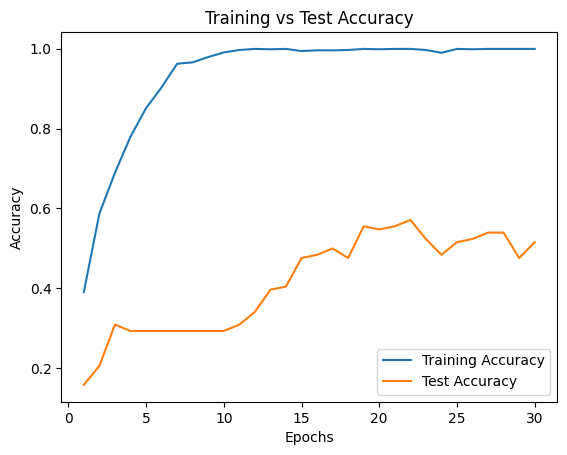

In [36]:
train_acc = batch_norm_cnn_history.history['accuracy']
val_acc = batch_norm_cnn_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.show()

The batch normalization appears to have improved this model. The accuracy on training, validation, and testing sets are all higher. The validation accuracy shows more stability from one epoch to the next, and convergence around 20 epoches is more obvious.

#### Fit a pretrained deep learning model

In this course we also learned that pre-trained models can be used for deep learning tasks. Here, I implemented the **MobileNetV2**, which is designed to work with image data. I had to do some reshaping of the dataset, such as transforming it back to 3 channels, in order for it to fit into the model.

In [46]:
pretrained_model = MobileNetV2(
    input_shape=(149, 80, 3),
    include_top=False,
    weights='imagenet'
)
pretrained_model.trainable = False

inputs = Input(shape=(149, 80, 3))
x = pretrained_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(len(set(y)), activation='softmax')(x)
mobilenet_model = Model(inputs, outputs)

mobilenet_model.compile(optimizer=Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

X_train_3_channels = np.repeat(X_train, 3, axis=-1)
X_test_3_channels = np.repeat(X_test, 3, axis=-1)

mobilenet_history = mobilenet_model.fit(
    X_train_3_channels, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32
)

loss, acc = mobilenet_model.evaluate(X_test_3_channels, y_test)
print(f"Test accuracy: {acc:.4f}")

<ipython-input-46-1772447800>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = MobileNetV2(


Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - accuracy: 0.2888 - loss: 1.6966 - val_accuracy: 0.3889 - val_loss: 1.3807
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step - accuracy: 0.4428 - loss: 1.2809 - val_accuracy: 0.4841 - val_loss: 1.2712
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.5221 - loss: 1.1917 - val_accuracy: 0.5079 - val_loss: 1.1866
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 305ms/step - accuracy: 0.5822 - loss: 1.0687 - val_accuracy: 0.5635 - val_loss: 1.1473
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 325ms/step - accuracy: 0.6162 - loss: 1.0008 - val_accuracy: 0.5238 - val_loss: 1.1241
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 332ms/step - accuracy: 0.6329 - loss: 0.9780 - val_accuracy: 0.5556 - val_loss: 1.1415
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.6605 - loss: 0.9138 - val_accuracy: 0.5476 - val_loss: 1.0761
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 351ms/step - accuracy: 0.6538 - loss: 0.9177 - val_accu

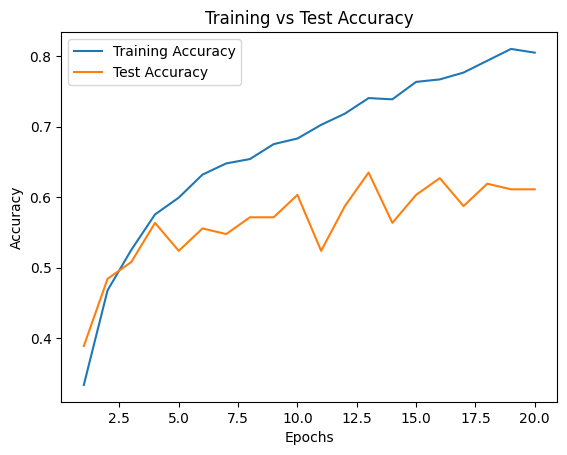

In [47]:
train_acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.show()

This model outperforms all of the other models I built and tested. It converged around 10 epochs. The fact that the pretrained model has the best performance is not surprising, as it can leverage all of the knowledge from pretraining and apply it to the task presented here.

#### Compare evaluation metrics

In the previous section, I fitted 4 deep learning models, attempting to score x-ray images for osteoarthritis. Now, we can use various classification metrics to evaluate the models' performance.

In [50]:
models = {
    "Simple ANN": simple_ann,
    "Simple CNN": simple_cnn,
    "CNN w/ Batch Normalization": batch_norm_cnn,
    "Pretrained MobileNetV2": mobilenet_model
}

results = []

for name, model in models.items():
    if model == mobilenet_model:
        y_pred_probs = model.predict(X_test_3_channels)
    else:
        y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

pd.DataFrame(results)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step


,Model,Accuracy,Precision,Recall,F1 Score
0,Simple ANN,0.346032,0.209426,0.346032,0.259580
1,Simple CNN,0.504762,0.513834,0.504762,0.480010
2,CNN w/ Batch Normalization,0.539683,0.518066,0.539683,0.510718
3,Pretrained MobileNetV2,0.685714,0.694615,0.685714,0.673186


The table above shows **various evaluation metrics** for the four deep learning models using the unseen test dataset.

First, **accuracy** shows the number of correct predictions out of all predictions made. Accruacy increased with each model as we added complexity, and the pretrained MobileNetV2 has the highest accuracy, near 70%.

However, accuracy can sometimes be misleading, especially when there is an imbalance in the number of samples in each class. Therefore, we can take a look at other metrics like **precision** and **recall** to better understand performance. Similar to accuracy, we see precision and recall generally increases with the more complex models. The pretrained MobileNetV2 has the best numbers here as well, near 70%.

Finally, the **F1 score** brings precision and recall into one metric. Once again, the pretrained MobileNetV2 model performed best.

I would perfer to use the pretrained MobileNetV2 moving forward, since it is clearly the best model out of the four choices here. In the next section, we'll take a closer look at how MobileNetV2 performed.

#### Analysis of best model

Ok, so we know that the MobileNetV2 is the best model of the four trained for this task. But how did it do with the different classes it needed to predict. We can take a closer lookm at this in a **confusion matrix**.

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step


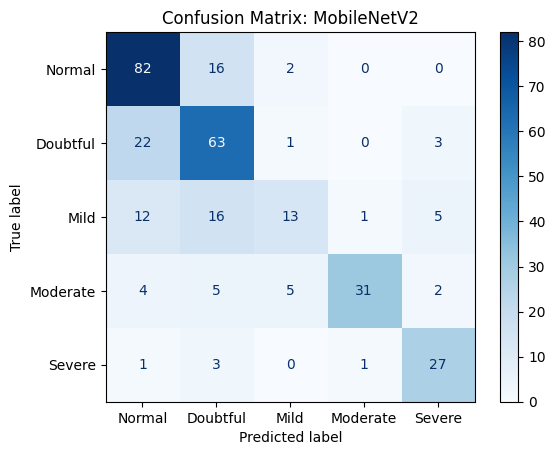

In [55]:
y_pred_probs = mobilenet_model.predict(X_test_3_channels)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = ['Normal', 'Doubtful', 'Mild', 'Moderate', 'Severe']

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cm_plot.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: MobileNetV2")
plt.show()

Recall from the data exploration at the beginning of the notebook that the most samples in the dataset were for the "Normal" or "Doubtful" classes. The other ones that show further progression of osteoarthritis are less common.

Looking at the confusion matrix, it's good to see that the majority of moderate and severe cases are properly classified. It's really important that the model classify those correctly, since they are more likely to have impacts on patient outcomes.

We can see that the model had more difficulty properly classifying normal and doubtful cases, although it's important to consider that these classes had more samples in the dataset overall.

Probably the most glaring issue that could be examined further is "Doubtful" cases being classified as "Mild", which happened 16 times, while "Mild" cases were only classified correctly 13 times.

However, overall, these results are satisfactory, and a good starting point for future development in this area.

#### Conclusion/discussion

Learning and key takeaways:
* If there's one thing I've learned, it's that **getting the data in the right format is just as important as the machine learning model you're designing**.
* When put into practice, **machine learning models like this one can have a serious affect on people**. For example, this one is about osteoarthritis, and when the model makes a correct prediction, the model has a positive affect on the doctor and patient. But if it's wrong too often, people can lose trust in the model.
* This is the first example I've coded where the **pretrained model performed really well**, and I'll need to consider using those more in the future.

What didn't work and why:
* When I got to model training, I noticed that my images weren't all the same size. Some x-rays showed both knees, while most showed only one knee. **I had to crop the two-knee images down to just one knee** before training the models.
* Some of the more complex models that I didn't include here would take so long to train, they couldn't complete in a reasonable amount of time. I could not include them for that reason. A possibly solution would be to **use a GPU or other enhanced processor to increase training speed**.

Suggestions for improvement:
* The Kaggle dataset has two separate directories of images for training, one contains images labeled by doctor A, and one by doctor B. I only used doctor A's images in this model, but a future iteration of this could include those from doctor B as well, thus **increasing the size of the training set** and improving performance.
* I would be interested to see whether **balancing the class sizes** would alleviate these inequity in model performance across the five classes.
* A future iteration of this project could also **try other pretrained models** to see if any of them could improve on MobileNetV2.